In [1]:
batch_size = 32
image_size = 256
vertical_type = "coronal"
checkpoint = f"checkpoint/{vertical_type}_segmentation_detection_142529-epoch-20.pth"

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from tqdm import tqdm

from PIL import Image, ImageOps

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF
import torchvision.models as models

In [4]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")

IMAGES_DIR = os.path.join(DATA_DIR, f"train_{vertical_type}_images_jpeg95")
LABEL_DIR = os.path.join(DATA_DIR, f"train_{vertical_type}_labels_jpeg95")

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
class DetectionModel(nn.Module):
    def __init__(self, backbone, channels, deep=4, out_channels=64, n_features=1):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels
        self.out_channels = out_channels
        self.n_features = n_features

        self.init_layers()

    def init_layers(self):
        self.parallel_modules = self.make_parallel_modules()
        self.upsampling_modules = self.make_upsampling_modules()

        self.downsampling_modules = self.make_downsampling_modules()
        self.classification_modules = self.make_classification_modules()

    def make_classification_modules(self):
        # the last layer
        return nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(self.out_channels, 2 * self.out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(2 * self.out_channels, self.n_features, kernel_size=1, padding='same'),
        )

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(self.channels[i], self.channels[i], kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i], kernel_size=1, padding='same'),
            )
            parallel_modules.append(module)

        return parallel_modules

    def make_downsampling_modules(self):
        return nn.ModuleList([
            nn.Sequential(
                self.backbone.conv1,
                self.backbone.bn1,
                self.backbone.relu,
                self.backbone.maxpool),
            nn.Sequential(
                self.backbone.layer1,
                self.backbone.layer2,
            ),
            self.backbone.layer3,
            self.backbone.layer4
        ])

    def make_upsampling_modules(self):
        upsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i] // 2, kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i] // 2, self.channels[i - 1] if i > 0 else self.out_channels, kernel_size=1),
                nn.Upsample(scale_factor=2)
            )
            upsampling_modules.append(module)

        return upsampling_modules

    def forward(self, x):

        downsampling_outputs = []
        out = x
        for module in self.downsampling_modules:
            out = module(out)
            downsampling_outputs.append(out)

        parallel_outputs = []
        for i in range(len(self.parallel_modules)):
            module = self.parallel_modules[i]
            out = module(downsampling_outputs[i])
            parallel_outputs.append(out)

        out = 0
        for i in range(len(self.upsampling_modules)):
            module = self.upsampling_modules[-(i + 1)]
            parallel_output = parallel_outputs[-(i + 1)]

            up_input = out + parallel_output
            out = module(up_input)

        out = self.classification_modules(out)

        return out

def resnet50_gray():
    model = models.resnet50(pretrained=True)
    conv1_weight = model.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return model

backbone = resnet50_gray()
channels = [64, 512, 1024, 2048]

model = DetectionModel(backbone, channels=channels, out_channels=channels[0], n_features=2).to(device)

In [7]:
state = torch.load(checkpoint)
model.load_state_dict(state["model"])
model = model.eval()

## Transform

In [8]:
class DataTransform(nn.Module):
    def __init__(self, image_size):
        super().__init__()

        self.transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

    def forward(self, x):
        x = TF.center_crop(x, max(x.width, x.height))
        x = self.transform(x)
        return x


transform = DataTransform(image_size)

## Dataset

In [9]:
class VerticalImageDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        super().__init__()
        self.df = df
        self.image_dir = image_dir

        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        df = self.df.iloc[idx]

        UID = df.name
        image_name = int(df[f"{vertical_type}_index"])
        image_path = os.path.join(self.image_dir, UID, f"{image_name}.jpeg")
        image = Image.open(image_path)

        left, top, right, bottom = df[['left','top','right','bottom']]
        image = TF.crop(image, top, left, bottom-top, right-left)

        if self.transform:
            image = self.transform(image)

        return image, UID, image_name

## Inference

In [10]:
df = pd.read_csv(f'infer_{vertical_type}_position.csv').set_index("UID")
df.head()

,direction,coronal_index,bottom,right,top,left,z_spacing,pixel_spacing,aspect,width,height,coronal_left,coronal_top,coronal_right,coronal_bottom,sagittal_left,sagittal_top,sagittal_right,sagittal_bottom
UID,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,2,49,590,432,98,88,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,50,590,432,98,88,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,51,590,432,98,88,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,52,590,432,98,88,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,53,590,432,98,88,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213


### Inference images

In [11]:
dataset = VerticalImageDataset(df, IMAGES_DIR, transform)
len(dataset)

555194

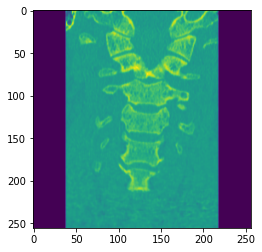

In [12]:
x, _, _ = dataset[100]
img = x * 0.5 + 0.5
plt.imshow(img.squeeze().cpu().numpy())

In [13]:
def predict(model, x):
    x = x.to(device)
    classification_prob, mse_score = model(x).sigmoid().chunk(2, dim=1)
    mse_score = torch.round(mse_score * 8.) / 8.
    pred = classification_prob.gt(0.5).float() * mse_score
    return pred

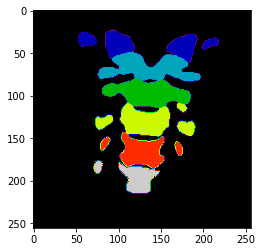

In [14]:
with torch.no_grad():
    x = x.unsqueeze(0)
    pred = predict(model, x)
    pred = pred.squeeze().cpu().numpy()
    pred = pred * 32
    Image.fromarray(np.uint8(pred), 'L').save('sample_infer.png')
    plt.imshow(pred, cmap='nipy_spectral')

In [15]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=16)

In [16]:
def save_pred_image(pred, UIDs, image_names):
    pred = pred * 32
    for i in range(pred.shape[0]):
        label_dir = os.path.join(LABEL_DIR, UIDs[i])
        if os.path.exists(label_dir) == False:
            os.mkdir(label_dir)
        label = pred[i, 0, :, :]
        img_path = os.path.join(label_dir, f"{image_names[i]}.png")
        img_full_path = os.path.join(LABEL_DIR, img_path)
        Image.fromarray(np.uint8(label), 'L').save(img_full_path)

In [17]:
with torch.no_grad():
    train_iter = tqdm(dataloader)
    for x, UIDs, image_names in train_iter:
        pred = predict(model, x)
        save_pred_image(pred.cpu().numpy(), UIDs, image_names)

100%|██████████| 17350/17350 [1:38:37<00:00,  2.93it/s]
